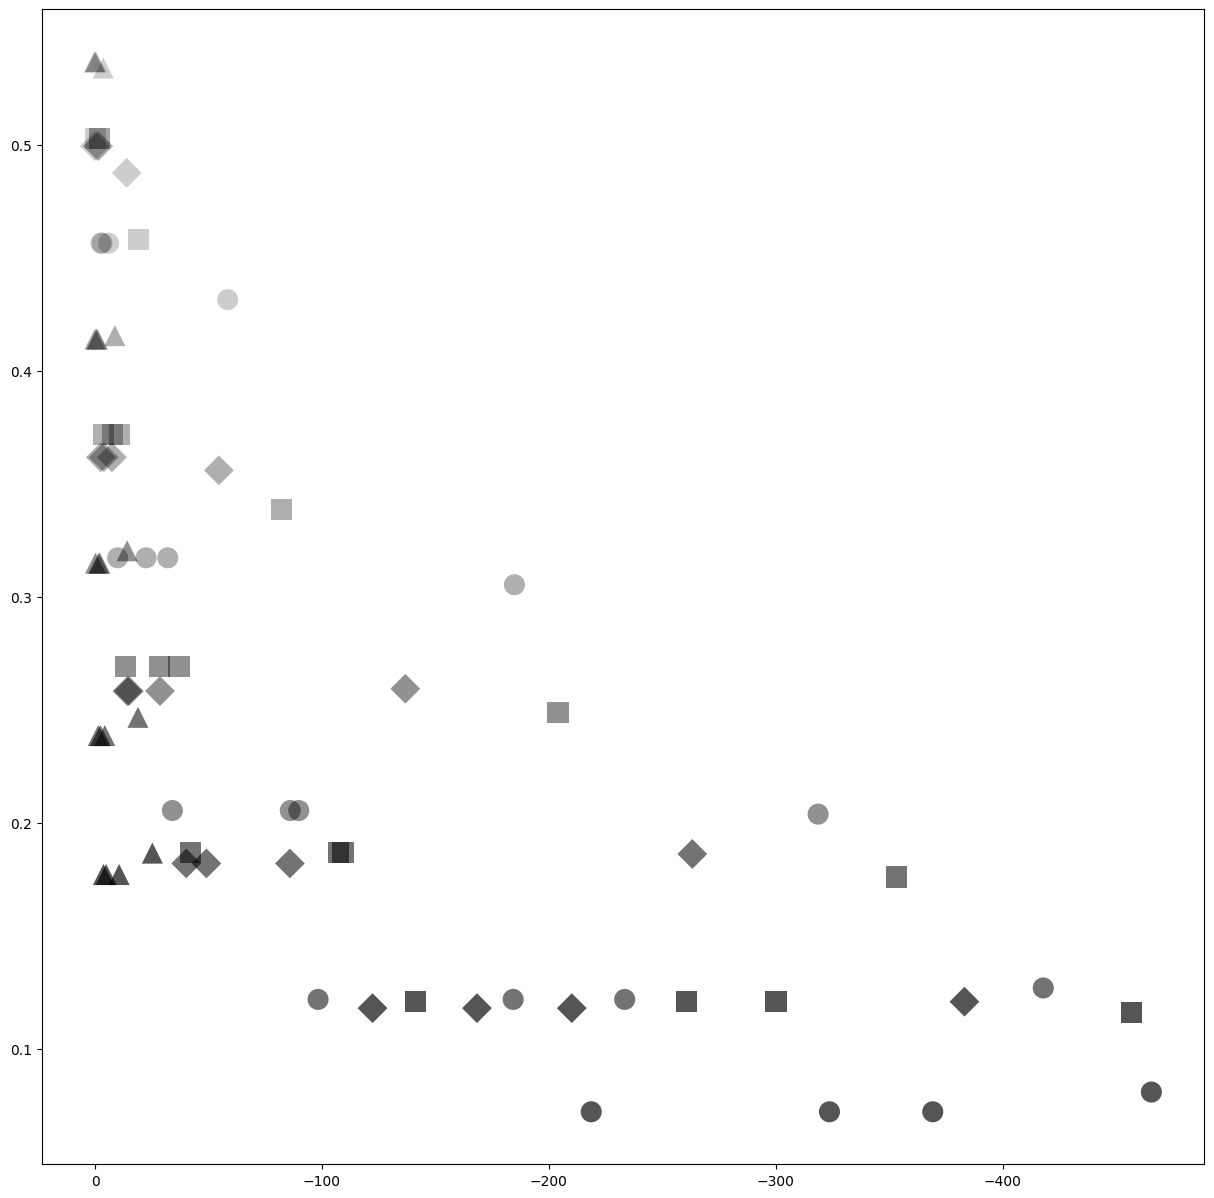

In [37]:
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
from scipy import optimize
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


datapath = Path.cwd().parent / "data" / "eval" / "eval_cls_generalizability.csv"
data = pd.read_csv(datapath)


"""
preprocessing
"""


def get_quality(cs, psnr, ssim, lpips):
    # weighted average metric:
    # - Cosine Similarity: already in the range [-1, 1], can be used as is.
    # - PSNR: normalize to [0, 1] by using a formula like: (PSNR - 30) / 20, clamped to [0, 1].
    # - SSIM: already in the range [-1, 1], can be used as is.
    # - LPIPS: invert and normalize to [0, 1] using: 1 - LPIPS, clamped to [0, 1].

    # create a boolean mask for valid entries
    valid_mask = ~(np.isnan(cs) | np.isnan(psnr) | np.isnan(ssim) | np.isnan(lpips) |
                   np.isinf(cs) | np.isinf(psnr) | np.isinf(ssim) | np.isinf(lpips))
    
    # initialize with NaN
    wam = pd.Series(np.nan, index=cs.index)
    
    psnr_n = np.clip((psnr - 30) / 20, 0, 1)
    
    lpips_n = np.clip(lpips, 0, 1)
    
    wam[valid_mask] = (0.15 * cs[valid_mask] + 
                       0.25 * psnr_n[valid_mask] + 
                       0.35 * ssim[valid_mask] + 
                       0.25 * (1 - lpips_n[valid_mask]))
    
    return wam


data["acc_rank_delta"] = data["acc_rank"] - data["adv_acc_rank"] # before - after (lower is better)
data["quality"] = get_quality(data["cosine_sim"], data["psnr"], data["ssim"], data["lpips"])

data = data.drop(columns=["density", "img_id", "acc_rank", "adv_acc_rank", "cosine_sim", "psnr", "ssim", "lpips"])

data = data.groupby(['model', 'mask', 'opacity']).agg({
    'acc_rank_delta': 'mean',
    'quality': 'mean',
}).reset_index()


"""
plot
"""


plt.figure(figsize=(15, 15))

adv_acc = data['acc_rank_delta'] # x-axis
quality = data['quality'] # y-axis

# invert order of x-axis
plt.gca().invert_xaxis()

model = data['model'] # "model": ["vit", "eva02", "eva01", "convnext", "resnet"],
mask = data['mask'] # "mask": ["circle", "square", "diamond", "knit"],
opacity = data['opacity'] # "opacity": [50, 80, 110, 140, 170],

markers = {'circle': 'o', 'square': 's', 'diamond': 'D', 'knit': '^'}

for mask in markers:
    mask_data = data[data['mask'] == mask]
    plt.scatter(mask_data['acc_rank_delta'], mask_data['quality'],
                marker=markers[mask],
                c='black',
                alpha=mask_data['opacity']/255,
                s=230,
                edgecolors='none')

# """
# maxy regression line
# """

# x = data['adv_acc']
# y = data['quality']

# # gray max-y points
# max_coords = []
# for x_elem in x:
#     y_elem = y[x == x_elem]
#     max_y = y_elem.max()
#     max_coords.append((x_elem, max_y))
#     plt.scatter(x_elem, max_y, marker='o', facecolors='none', edgecolors='gray', s=3)
# max_coords = sorted(max_coords, key=lambda x: x[0])
# max_x, max_y = zip(*max_coords)
# plt.plot(max_x, max_y, color='gray', linestyle='--')

# max_coords_df = []
# for x_elem, y_elem in max_coords:
#     max_coords_df.append(data[(data['adv_acc'] == x_elem) & (data['quality'] == y_elem)].iloc[0])
# max_coords_df = pd.DataFrame(max_coords_df)
# max_coords_df = max_coords_df.drop_duplicates(subset=['opacity', 'density', 'perturb', 'epsilon']).reset_index(drop=True)

# # red max-y regression line
# x = np.array(max_x).reshape(-1, 1)
# y = np.array(max_y)
# maxy_degree = 1
# polyreg = make_pipeline(PolynomialFeatures(maxy_degree), LinearRegression())
# polyreg.fit(x, y)
# x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
# y_smooth = polyreg.predict(x_smooth)
# plt.plot(x_smooth, y_smooth, color='red', linestyle='--')

# # print stuff
# print("\nAll above the max-y regression line (sorted by final_score):")
# above = pd.DataFrame([data[(data['adv_acc'] == x_elem) & (data['quality'] == y_elem)].iloc[0] for x_elem, y_elem in max_coords if y_elem > polyreg.predict([[x_elem]])])
# above['final_score'] = -above['adv_acc'] + above['quality']
# above = above.sort_values(by='final_score', ascending=False)
# above = above.drop_duplicates(subset=['opacity', 'density', 'perturb', 'epsilon']).reset_index(drop=True)
# display(HTML(above.to_html()))

# print("\nMax Quality per Accuracy (sorted by final_score):")
# max_coords_df['final_score'] = -max_coords_df['adv_acc'] + max_coords_df['quality']
# max_coords_df = max_coords_df.sort_values(by='final_score', ascending=False)
# display(HTML(max_coords_df.to_html()))

# """
# polynomial regression
# """

# x = data['adv_acc'].values.reshape(-1, 1)
# y = data['quality'].values

# total_degree = 1
# polyreg = make_pipeline(PolynomialFeatures(total_degree), LinearRegression())
# polyreg.fit(x, y)

# x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
# y_smooth = polyreg.predict(x_smooth)

# plt.plot(x_smooth, y_smooth, color='gray')

# """
# legend
# """

# # legend for markers
# legend_elements = [
#     plt.Line2D([0], [0], marker='o', color='w', label='perturb = True', markerfacecolor='gray', markersize=10),
#     plt.Line2D([0], [0], marker='s', color='w', label='perturb = False', markerfacecolor='gray', markersize=10),
#     plt.Line2D([0], [0], marker='None', color='w', label=''),
#     plt.Line2D([0], [0], marker='o', color='w', label='Low Density', markerfacecolor='gray', markersize=5),
#     plt.Line2D([0], [0], marker='o', color='w', label='High Density', markerfacecolor='gray', markersize=10),
#     plt.Line2D([0], [0], marker='None', color='w', label=''),
#     plt.Line2D([0], [0], marker='o', color='w', label='Low Opacity', markerfacecolor='gray', markersize=10, alpha=0.3),
#     plt.Line2D([0], [0], marker='o', color='w', label='High Opacity', markerfacecolor='gray', markersize=10, alpha=1),
#     plt.Line2D([0], [0], marker='None', color='w', label=''),
#     plt.Line2D([0], [0], color='gray', linestyle='--', label=f'Max quality per accuracy'),
#     plt.Line2D([0], [0], color='red', linestyle='--', label=f'Poly Regression for max quality (degree={maxy_degree})'),
#     plt.Line2D([0], [0], color='gray', label=f'Poly Regression for full dataset (degree={total_degree})'),
# ]

# plt.legend(handles=legend_elements, title='Legend', loc='upper left')

# plt.xlabel('Adversarial Accuracy (lower is better)')
# plt.ylabel('Perceptual Quality (higher is better)')
# plt.title('Trade-off between Adversarial Accuracy and Perceptual Quality')
# plt.show()
